# Peak method applied to NN
The script takes the ECG datasets and for every sample extracts relevant peaks which are then used to train the Neural Network

In [263]:
# Importing packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

In [264]:
# Load data from files

#v_data_csv = np.genfromtxt('src/dataset_data.csv', delimiter=';')
#v_categ_csv = np.genfromtxt('src/dataset_categ.csv', delimiter=';', dtype=str)

In [265]:
# Delete samples with unusable symbols

#print("data size: " + str(len(v_data_csv)) + " categoy size: " + str(len(v_categ_csv)))

#Delete values used for padding (-20.0)
v_data = np.empty(len(v_data_csv), dtype=object)
for n in range(0,len(v_data_csv),1):
    v_data[n] = v_data_csv[n][v_data_csv[n] != -20]
    #print(v_data[n])

# Find indexes to delete
symbol_list = {'N':0, 'S':1, 'V':2, 'F':3, 'Q':4}
delete_index = np.empty(0, dtype=int)
for n in range(0,len(v_categ_csv),1):
    if not(v_categ_csv[n] in symbol_list):
        #print("Delete n = " + str(n) + " symbol = " + v_categ_csv[n]) 
        delete_index = np.append(delete_index, n)
print(delete_index)
v_data = np.delete(v_data, delete_index, axis=0)
v_categ = np.delete(v_categ_csv, delete_index)

# Convert symbols strings to numbers
tmp = np.empty(len(v_categ), dtype=int)
for n in range(len(v_categ)):
    tmp[n] = symbol_list[v_categ[n]]
v_categ = tmp
print("data size: " + str(len(v_data)) + " category size: " + str(len(v_categ)))


[     6    229    257 ... 101653 101654 102402]
data size: 76669 categoy size: 76669


In [266]:
# Calculate moving averages

# Window size for moving averages
LOWPASS_WINDOW = 5

v_data_lp = np.zeros_like(v_data)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for i in range(0, len(v_data)):
    tmp_lowpass = moving_average(v_data[i], LOWPASS_WINDOW)
    v_data_lp[i] = np.pad(tmp_lowpass, (LOWPASS_WINDOW-1,0), 'constant', constant_values=(tmp_lowpass[0],0))

In [267]:
# Define time array

FREQ_SAMPL = 360

#v_time = np.arange(0, len(v_data_lp[0]), 1)/FREQ_SAMPL

In [268]:
# Identify potential peaks
# Compare 3 signal samples S0, S1, S2
# Peak if:  S1>=S0 and S1>S2
#           S1<=S0 and S1<S2

DELTA_PEAK = 0.1        # Minimum signal amplitude from one peak to the next
DELTA_TIME = 0.3        # Maximum time after a peak in which DELTA_PEAK is considered (after this time peaks with any amplitude are considered)

v_peaks_data = np.empty((len(v_data_lp)), dtype=object)
v_peaks_time = np.empty((len(v_data_lp)), dtype=object)
#j = 0

for n in range(len(v_data_lp)):
    j = 0
    tmp_peaks_data = np.ones((1, len(v_data_lp[n])), dtype=float)*-20.0
    tmp_peaks_time = np.ones((1, len(v_data_lp[n])), dtype=float)*-20.0
    v_time = np.arange(0, len(v_data_lp[n]), 1)/FREQ_SAMPL
    # Walk through all samples
    for i in range(1, len(v_data_lp[n])-1):
        # Identify peak
        if  ((v_data_lp[n][i] >= v_data_lp[n][i-1]) and (v_data_lp[n][i] > v_data_lp[n][i+1])) or \
            ((v_data_lp[n][i] <= v_data_lp[n][i-1]) and (v_data_lp[n][i] < v_data_lp[n][i+1])):
            # Check if peak value and time
            if  (abs(v_data_lp[n][i] - tmp_peaks_data[0][j-1]) > DELTA_PEAK) or \
                (abs(v_time[i] - tmp_peaks_time[0][j-1]) > DELTA_TIME):
                #print("n:", str(n), " i:", str(i), " j:", str(j))
                tmp_peaks_data[0][j] = v_data_lp[n][i]
                tmp_peaks_time[0][j] = v_time[i]
                j += 1
    v_peaks_data[n] = tmp_peaks_data
    v_peaks_time[n] = tmp_peaks_time
    #v_peaks_time[n] = np.append(v_peaks_time, tmp_peaks_time, axis=0)


#v_peaks_data[n] = v_peaks_data[n][v_peaks_time[n] != 0]
#v_peaks_time[n] = v_peaks_time[n][v_peaks_time[n] != 0]

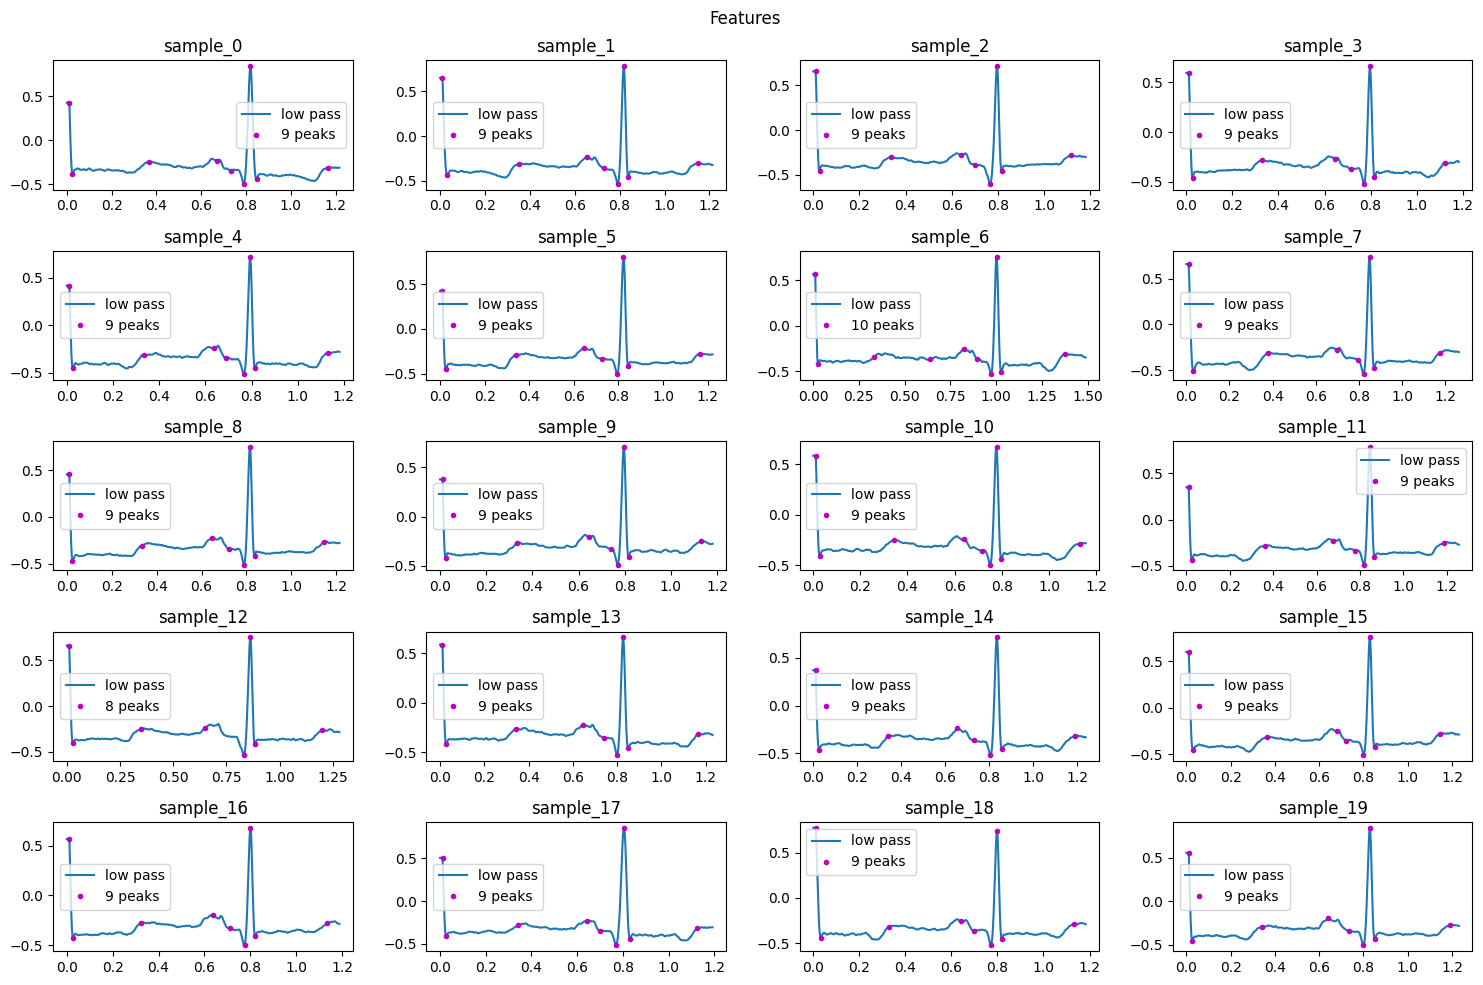

In [269]:
# Plot results
N_ROW = 5
N_COL = 4

fig, axs = plt.subplots(N_ROW, N_COL)
fig.set_size_inches(15, 2*N_ROW)
fig.suptitle("Features")
for i, ax in enumerate(axs.flatten()):
    ax.title.set_text('sample_'+str(i))
    #ax.plot(axis_x, linewidth=0.5, color="black")
    v_data_plot = v_data[i][v_data[i] != -20]
    v_data_lp_plot = v_data_lp[i][v_data_lp[i] != -20]
    
    v_time_plot = np.arange(0, len(v_data_lp_plot))/FREQ_SAMPL
    #ax.plot(v_time_plot, v_data_plot, linewidth=0.5, label="original")
    ax.plot(v_time_plot, v_data_lp_plot, label="low pass")

    v_peaks_data_plot = v_peaks_data[i][v_peaks_time[i] != -20.0]
    v_peaks_time_plot = v_peaks_time[i][v_peaks_time[i] != -20.0]
    #print(v_peaks_data_plot)
    ax.plot(v_peaks_time_plot, v_peaks_data_plot, 'm.', label=str(len(v_peaks_data_plot))+" peaks")
    ax.legend()
plt.tight_layout()
plt.show()

In [270]:
# Delete samples with too many peaks

MAX_PEAK_NUM = 40       # Maximum peaks for each array

n_offset = 0
delta_num_train = 0
delta_num_test = 0
delta_num_valid = 0
del_peak_cat = [0,0,0,0,0]      # Log the category of each deleted peak

print('Samples before peak check: ' + str(len(v_peaks_data)))

for n in range(len(v_peaks_data)-1,-1,-1):
    #index = n-n_offset
    if len(v_peaks_data[n][v_peaks_data[n] != -20]) > MAX_PEAK_NUM:
        # Delete from peak set
        v_peaks_data = np.delete(v_peaks_data, n, 0)
        v_peaks_time = np.delete(v_peaks_time, n, 0)
        # Delete from category set
        v_categ = np.delete(v_categ, n)
        # Delete from samples set
        v_data_lp = np.delete(v_data_lp, n, 0)
        
        #n_offset += 1
        #if n < num_train:
        #    delta_num_train += 1
        #elif n < num_train+num_test:
        #    delta_num_test += 1
        #else:
        #    delta_num_valid += 1

#num_train -= delta_num_train
#num_test -= delta_num_test
#num_valid -= delta_num_valid

print('Samples after peak check: ' + str(len(v_peaks_data)))
#print('Categories: ')
#print(del_peak_cat)

Samples before peak check: 76669
Samples after peak check: 76527


In [271]:
# Create array combining peak amplitudes and peak times

# Find maximum length of peaks arrays
peak_length = np.zeros(len(v_peaks_data))
for i in range(len(v_peaks_data)):
    peak_length[i] = len(v_peaks_data[i][v_peaks_time[i] != -20])

max_length = int(np.max(peak_length))
peak_avg = np.ones(len(peak_length))*np.mean(peak_length)

<function matplotlib.pyplot.show(close=None, block=None)>

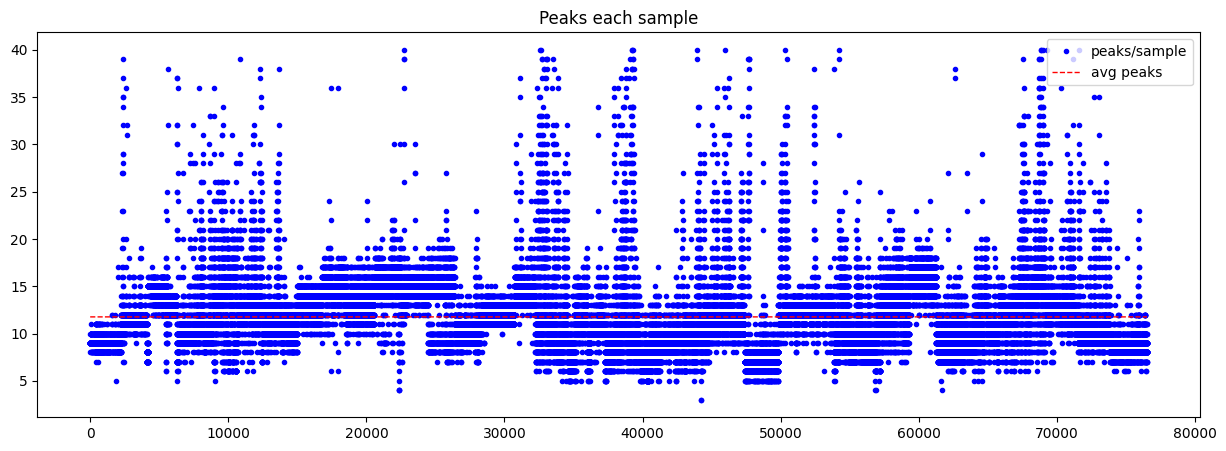

In [272]:
# Plot peaks data for all samples

plt.rcParams["figure.figsize"] = (15,5)
plt.title('Peaks each sample')
plt.plot(peak_length, 'b.', label="peaks/sample")
plt.plot(peak_avg, 'r--', linewidth=1, label='avg peaks')
plt.legend()
plt.show
#print(v_data[max_sample])

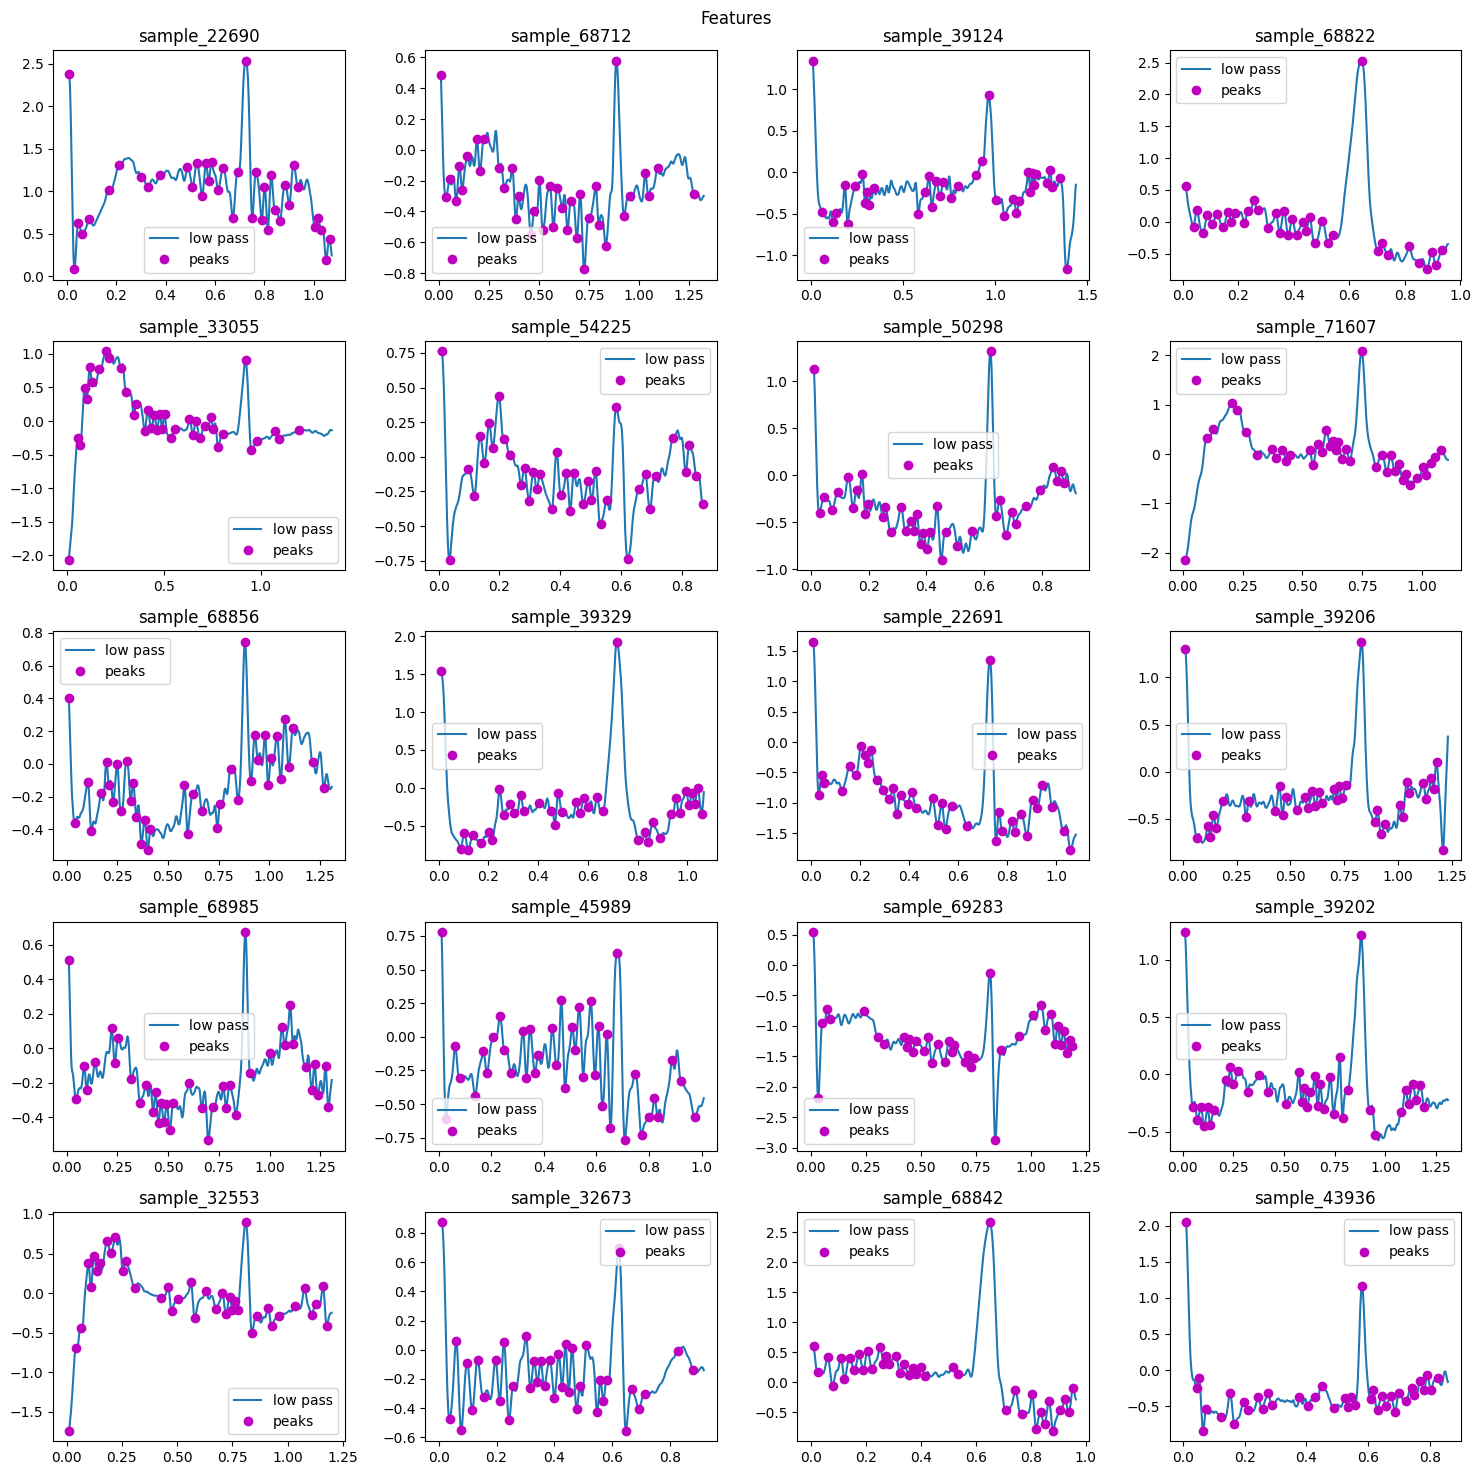

In [273]:
# Plot samples with high number of peaks
N_ROW = 5
N_COL = 4
N_TOT = N_ROW*N_COL

max_index = np.argpartition(peak_length, -N_TOT)[-N_TOT:]

fig, axs = plt.subplots(N_ROW, N_COL)
fig.set_size_inches(15, 15)
fig.suptitle("Features")
for n, ax in enumerate(axs.flatten()):
    i = max_index[n]
    ax.title.set_text('sample_'+str(i))
    v_data_plot = v_data[i][v_data[i] != -20]
    v_data_lp_plot = v_data_lp[i][v_data_lp[i] != -20]
    
    v_time_plot = np.arange(0, len(v_data_lp_plot))/FREQ_SAMPL
    #ax.plot(v_time_plot, v_data_plot, linewidth=0.5, label="original")
    ax.plot(v_time_plot, v_data_lp_plot, label="low pass")

    v_peaks_data_plot = v_peaks_data[i][v_peaks_time[i] != -20.0]
    v_peaks_time_plot = v_peaks_time[i][v_peaks_time[i] != -20.0]
    ax.plot(v_peaks_time_plot, v_peaks_data_plot, 'mo', label="peaks")
    ax.legend()
plt.tight_layout()
plt.show()

In [274]:
# Generate arrays for NN
# Each input array is made of 2*NUM_PEAKS
NUM_PEAKS = 8

# Define structure of arrays
input_peaks = np.zeros((len(v_peaks_data),2*NUM_PEAKS))
print(input_peaks)

# Fill strcuture with peaks data
# P0,dT0,P1,dT1,P2,dT2...,Pn,Tn  
# with Px: peak amplitude, Tx: delta time from previous peak
for n in range(len(v_peaks_data)):
    prev_time = 0
    tmp_data = v_peaks_data[n][v_peaks_time[n] != -20]
    tmp_time = v_peaks_time[n][v_peaks_time[n] != -20]
    for i in range(0,len(tmp_data)):
        # Copy peaks to structure
        if(i >= NUM_PEAKS):
            break
        input_peaks[n][2*i] = tmp_data[i]
        input_peaks[n][2*i+1] = tmp_time[i] - prev_time
        prev_time = tmp_time[i]

print(input_peaks)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.426       0.01111111 -0.385      ...  0.03055556 -0.439
   0.02777778]
 [ 0.651       0.01111111 -0.439      ...  0.02777778 -0.452
   0.01944444]
 [ 0.653       0.01111111 -0.452      ...  0.03055556 -0.459
   0.01944444]
 ...
 [ 1.266       0.01111111 -0.294      ...  0.07222222 -0.355
   0.02777778]
 [ 1.201       0.01111111 -0.355      ...  0.03055556 -0.205
   0.19722222]
 [ 1.418       0.01111111 -0.306      ...  0.02777778  0.
   0.        ]]


In [302]:
# Generate sets for training, test and validation

#DATA_SPLIT = 0.1
TEST_SPLIT = 0.1
VALID_SPLIT = 0.1
SEED = 12345

# Split data into sets
X_train, X_test, y_train, y_test = train_test_split(input_peaks, v_categ, test_size=TEST_SPLIT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=VALID_SPLIT, random_state=SEED)

print(len(v_categ[v_categ == 1]))
print(len(y_train[y_train != 0]))
print(len(y_test[y_test != 0]))
print(len(y_valid[y_valid != 0]))

# Convert y sets to categories
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_valid=to_categorical(y_valid)

num_train = len(y_train)
num_test = len(y_test)
num_valid = len(y_valid)

print(y_train)

2
3653
439
383
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [294]:
# Define NN structure
im_shape=(input_peaks[0].shape[0],1)
print(im_shape)
model = Sequential([
    Input(shape=(im_shape), name='inputs_cnn'),
    #Convolution1D(1, (3), strides=1, padding="same", activation='relu'),
    #MaxPool1D(2),
    #Convolution1D(1, (5), strides=3, activation='relu'),
    #MaxPool1D(2),
    Flatten(),
    Dense(30, activation='relu'),
    Dense(5, activation='softmax', name='main_output')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

(16, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 665 (2.60 KB)

 Trainable params: 665 (2.60 KB)

 Non-trainable params: 0 (0.00 B)

In [295]:
# Training parameters
EPOCH_NUM = 20
BATCH_SIZE = 32

# Train model
history=model.fit(X_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(X_valid,y_valid))
#history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid), callbacks=[tensorboard_callback])


Epoch 1/20
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9255 - loss: 0.3616 - val_accuracy: 0.9544 - val_loss: 0.1587
Epoch 2/20
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9546 - loss: 0.1562 - val_accuracy: 0.9627 - val_loss: 0.1314
Epoch 3/20
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9609 - loss: 0.1402 - val_accuracy: 0.9663 - val_loss: 0.1185
Epoch 4/20
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9657 - loss: 0.1252 - val_accuracy: 0.9689 - val_loss: 0.1117
Epoch 5/20
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9682 - loss: 0.1177 - val_accuracy: 0.9689 - val_loss: 0.1079
Epoch 6/20
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9702 - loss: 0.1153 - val_accuracy: 0.9710 - val_loss: 0.1069
Epoch 7/20
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9716 - loss: 0.1098 - val_accuracy: 0.9743 - val_loss: 0.1024
Epoch 8/20
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9734 - loss: 0.1050 - 

In [301]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test_a=np.argmax(y_test, axis=1)

print(y_prediction)
print(y_test_a)
print(len(y_test_a[y_test_a == 0]))
print(len(y_test_a[y_test_a == 1]))
print(len(y_test_a[y_test_a == 2]))
print(len(y_test_a[y_test_a == 3]))
print(len(y_test_a[y_test_a == 4]))

# Create confusion matrix and normalize it over predicted (columns)
result = confusion_matrix(y_test_a, y_prediction , normalize='pred')
#print(result)
classes = [0,1,2,3,4]
result_norm = np.around(result, 4)
#print(result_norm)
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
7214
0
363
75
1


ValueError: Shape of passed values is (4, 4), indices imply (5, 5)

In [ ]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
#plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()